In [301]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda")

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Pobranie danych

In [348]:
df_raw = pd.read_csv('data/train_data.csv')
evaluation_df_raw = pd.read_csv('data/test_data.csv')


df_raw.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Preprocessing

In [303]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalePrice                  4124 non-null   int64  
 1   YearBuilt                  4124 non-null   int64  
 2   Size(sqf)                  4124 non-null   int64  
 3   Floor                      4124 non-null   int64  
 4   HallwayType                4124 non-null   object 
 5   HeatingType                4124 non-null   object 
 6   AptManageType              4124 non-null   object 
 7   N_Parkinglot(Ground)       4124 non-null   float64
 8   N_Parkinglot(Basement)     4124 non-null   float64
 9   TimeToBusStop              4124 non-null   object 
 10  TimeToSubway               4124 non-null   object 
 11  N_manager                  4124 non-null   float64
 12  N_elevators                4124 non-null   float64
 13  SubwayStation              4124 non-null   objec

### Podział danych na zestaw treningowy, walidacyjny i testowy

In [349]:
train=df_raw.sample(frac=0.8,random_state=200) #random state is a seed value
test=df_raw.drop(train.index)
train, val = train_test_split(train, test_size=0.2, random_state=200)

### Znalezienie nazw kolumn z kategorycznymi wartościami

In [350]:
categorical_cols = df_raw.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')


### Oddzielenie danych numerycznych

In [351]:
train_num = train.drop(columns=categorical_cols)
val_num = val.drop(columns=categorical_cols)
test_num = test.drop(columns=categorical_cols)

X_train_num = train_num.drop(columns=['SalePrice'])
X_val_num = val_num.drop(columns=['SalePrice'])
X_test_num = test_num.drop(columns=['SalePrice'])

X_train_num.head()

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
2846,2007,868,21,0.0,1270.0,14.0,16.0,10,9.0,10.0
1046,2006,811,18,111.0,184.0,3.0,0.0,5,6.0,9.0
2908,1992,644,4,142.0,79.0,4.0,8.0,3,9.0,14.0
524,2009,1160,14,25.0,203.0,2.0,5.0,5,6.0,5.0
2450,2007,1643,16,0.0,1270.0,14.0,16.0,10,9.0,10.0


### Oddzielenie danych kategorycznych

In [352]:
X_train_cat = train[categorical_cols]
X_val_cat = val[categorical_cols]
X_test_cat = test[categorical_cols]

X_train_cat.head()

,HallwayType,HeatingType,AptManageType,TimeToBusStop,TimeToSubway,SubwayStation
2846,terraced,individual_heating,management_in_trust,0~5min,0-5min,Kyungbuk_uni_hospital
1046,terraced,individual_heating,management_in_trust,5min~10min,10min~15min,Kyungbuk_uni_hospital
2908,mixed,individual_heating,self_management,5min~10min,15min~20min,Myung-duk
524,terraced,individual_heating,management_in_trust,0~5min,no_bus_stop_nearby,no_subway_nearby
2450,terraced,individual_heating,management_in_trust,0~5min,0-5min,Kyungbuk_uni_hospital


### Dane testowe (do zwrotu zadania)

In [354]:
X_task_num = evaluation_df_raw.drop(categorical_cols, axis=1)
X_task_cat = evaluation_df_raw[categorical_cols]

### Wyciągnięcie docelowych wartości

In [355]:
prescaled_Y = df_raw['SalePrice'].values.astype(float)

HIGHEST_Y = prescaled_Y.max()
LOWEST_Y = prescaled_Y.min()

Y_train = (train['SalePrice'].values.astype(float) - LOWEST_Y) / (HIGHEST_Y - LOWEST_Y)
Y_val = (val['SalePrice'].values.astype(float) - LOWEST_Y) / (HIGHEST_Y - LOWEST_Y)
Y_test = (test['SalePrice'].values.astype(float) - LOWEST_Y) / (HIGHEST_Y - LOWEST_Y)

Y_val[0:5]

array([0.41940664, 0.07207713, 0.37129239, 0.06014463, 0.4012034 ])

### Przygotowanie danych kategorycznych do embeddingu

In [356]:
X_train_cat = X_train_cat.copy()
X_val_cat = X_val_cat.copy()
X_test_cat = X_test_cat.copy()
X_task_cat = X_task_cat.copy()

for col in categorical_cols:
    ecd = LabelEncoder()
    X_train_cat[col] = ecd.fit_transform(X_train_cat[col])
    X_val_cat[col] = ecd.transform(X_val_cat[col])
    X_test_cat[col] = ecd.transform(X_test_cat[col])
    X_task_cat[col] = ecd.transform(X_task_cat[col])

X_train_cat = X_train_cat.values
X_val_cat = X_val_cat.values
X_test_cat = X_test_cat.values
X_task_cat = X_task_cat.values

X_train_cat[0:5]

array([[2, 1, 0, 0, 0, 4],
       [2, 1, 0, 2, 1, 4],
       [1, 1, 1, 2, 2, 5],
       [2, 1, 0, 0, 4, 7],
       [2, 1, 0, 0, 0, 4]])

### Normalizacja danych numerycznych

In [357]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num.values)
X_val_num = scaler.transform(X_val_num.values)
X_test_num = scaler.transform(X_test_num.values)
X_task_num = scaler.transform(X_task_num)

X_train_num[:5]

C:\Users\mateu\Documents\GitHub\Python-Toolkit-Playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[ 0.46831916, -0.232743  ,  1.20019543, -0.90640138,  1.74437885,
         2.4463686 ,  0.64944203,  1.83471735, -0.27423407, -0.22329419],
       [ 0.35405379, -0.38078079,  0.80143983, -0.39324692, -0.95932587,
        -1.03121007, -1.43778892, -0.32565169, -1.1575177 , -0.45046202],
       [-1.24566142, -0.81450554, -1.05941964, -0.24993351, -1.22073379,
        -0.71506656, -0.39417345, -1.1897993 , -0.27423407,  0.68537715],
       [ 0.6968499 ,  0.52562602,  0.26976569, -0.79082605, -0.91202349,
        -1.34735359, -0.78552925, -0.32565169, -1.1575177 , -1.35913336],
       [ 0.46831916,  1.7800515 ,  0.53560276, -0.90640138,  1.74437885,
         2.4463686 ,  0.64944203,  1.83471735, -0.27423407, -0.22329419]])

### Ważenie przykładów

In [311]:
Y_train[0:5]

array([0.49799554, 0.25020026, 0.22534208, 0.41932689, 0.52655998])

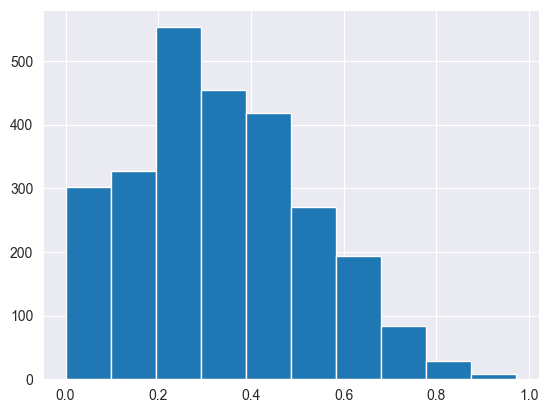

In [312]:
plt.hist(Y_train, bins=10)
plt.show()

Rozkład cen nie jest równomierny, co wpłynie negatywnie na naukę modelu. Możnaby obciążyć zakresy wartości

In [313]:
LOW_THRESHOLD = (100000 - LOWEST_Y) / (HIGHEST_Y - LOWEST_Y)
HIGH_THRESHOLD = (350000 - LOWEST_Y) / (HIGHEST_Y - LOWEST_Y)
bin_edges = np.array([LOW_THRESHOLD, HIGH_THRESHOLD])
bin_labels = np.digitize(Y_train, bins=bin_edges)

bin_counts = np.bincount(bin_labels)
bin_weights = bin_counts.sum() / (3 * bin_counts)

print(bin_weights)

print(LOW_THRESHOLD)
print(HIGH_THRESHOLD)

[2.44351852 0.45437328 2.56462585]
0.11948819254399479
0.5725755296590971


## Definicja sieci

In [314]:
class ApartmentPriceRegression(nn.Module):
    def __init__(self, num_categories_list, embedding_dim):
        super(ApartmentPriceRegression, self).__init__()
        self.emb_layers = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim) for num_categories in num_categories_list
        ])
        self.act_emb = nn.Tanh()
        total_input_size = X_train_num.shape[1] + X_train_cat.shape[1] * embedding_dim
        self.layers = nn.Sequential(
            self._make_block(total_input_size, out_features=4096, dropout=0.1),
            self._make_block(in_features=4096, out_features=2048, dropout=0.1),
            self._make_block(in_features=2048, out_features=512, dropout=0.1),
            self._make_block(in_features=512, out_features=10, dropout=0.1),
            nn.Linear(10, 1)
            )

    @staticmethod
    def _make_block(in_features, out_features, dropout=0.2):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x, cat_x):
        cat_x_embedded_list = [self.emb_layers[i](cat_x[:, i]) for i in range(cat_x.shape[1])]
        cat_x_embedded = torch.cat(cat_x_embedded_list, dim=1)
        cat_x_embedded = self.act_emb(cat_x_embedded)

        x = torch.cat([x, cat_x_embedded], dim=1).float()

        return self.layers(x)

## Przygotowanie do trenowania i ewaluacji

In [315]:
# Obliczam ile różnych labels ma każdy argument kategoryczny
num_categories = [np.unique(X_train_cat[:, i]).size for i in range(X_train_cat.shape[1])]
print(num_categories)

[3, 2, 2, 3, 5, 8]


In [316]:
X_train_num = torch.from_numpy(X_train_num)
X_train_cat = torch.from_numpy(X_train_cat)
Y_train = torch.from_numpy(Y_train)

X_val_num = torch.from_numpy(X_val_num).to(device=device)
X_val_cat = torch.from_numpy(X_val_cat).to(device=device)
Y_val = torch.from_numpy(Y_val).to(device=device)

X_test_num = torch.from_numpy(X_test_num).to(device=device)
X_test_cat = torch.from_numpy(X_test_cat).to(device=device)
Y_test = torch.from_numpy(Y_test).to(device=device)

In [317]:
def weighted_mse_loss(preds, target):
    # Standardowe MSE
    loss = (preds - target) ** 2

    bin_weights = [120, 20, 100]
    bin_edges = torch.tensor([LOW_THRESHOLD,HIGH_THRESHOLD]).to(device)
    # Każdemu targetowi przypisujemy konkretny koszyk, a następnie odpowiednią wagę konkretnego koszyka
    target_bin_labels = torch.bucketize(target, boundaries=bin_edges)
    weights = torch.tensor([bin_weights[b] for b in target_bin_labels]).to(device)

    # Nakładamy wagę
    weighted_loss = loss * weights

    return weighted_loss.mean()

In [319]:
def evaluate(model, X_num, X_cat, Y):
    model.eval()
    with torch.no_grad():
        preds = model(X_num, X_cat).squeeze(dim=1)

        # Tokenizacja gdzie 'cheap' = 0, 'average' = 1, 'expensive' = 2, bo torch nie ma typu string
        Y_labeld = torch.zeros_like(Y)

        Y_labeld[((Y>LOW_THRESHOLD) & (Y<HIGH_THRESHOLD))] = 1
        Y_labeld[Y>HIGH_THRESHOLD] = 2


        preds_labeld = torch.zeros_like(preds)
        preds_labeld[((preds>LOW_THRESHOLD) & (preds<HIGH_THRESHOLD))] = 1
        preds_labeld[preds>HIGH_THRESHOLD] = 2

        all_cheap = (Y_labeld==0).sum().item()
        all_average = (Y_labeld==1).sum().item()
        all_expensive = (Y_labeld==2).sum().item()

        assert(all_cheap+all_average+all_expensive == Y.shape[0])

        correct_cheap = ((preds_labeld==0) & (Y_labeld==preds_labeld)).sum().item()
        correct_average = ((preds_labeld==1) & (Y_labeld==preds_labeld)).sum().item()
        correct_expensive = ((preds_labeld==2) & (Y_labeld==preds_labeld)).sum().item()
        correct = (Y_labeld==preds_labeld).sum().item()

        assert(correct_cheap+correct_average+correct_expensive == correct)

        acc = correct / Y.shape[0]
        acc_cheap = correct_cheap / all_cheap
        acc_average = correct_average / all_average
        acc_expensive = correct_expensive / all_expensive

    model.train()
    return acc, acc_cheap, acc_average, acc_expensive

## Trenowanie i ewaluacja

In [318]:
train_dataset = data.TensorDataset(X_train_num,X_train_cat,Y_train)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
model = ApartmentPriceRegression(num_categories_list=num_categories, embedding_dim=8).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
loss_fn = weighted_mse_loss

In [320]:
model.train()
val_acc = []
val_acc_cheap = []
val_acc_average = []
val_acc_expensive = []
train_losses = []

for epoch in range(300):
    loader_losses = []
    for X_num, X_cat, Y in train_loader:
        optimizer.zero_grad()
        model.train()

        X_num = X_num.to(device, dtype=torch.float64)
        X_cat = X_cat.to(device)
        Y = Y.to(device)

        preds = model(X_num, X_cat).squeeze(dim=1)

        loss = loss_fn(preds, Y)
        loss.backward()
        optimizer.step()

        loader_losses.append(loss.item())

    acc, acc_cheap, acc_average, acc_expensive = evaluate(model, X_val_num, X_val_cat, Y_val)
    avg_loader_losses = sum(loader_losses)/len(loader_losses)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} train_loss: {avg_loader_losses:.3} {acc=:.3f} {acc_cheap=:.3f} {acc_average=:.3f} {acc_expensive=:.3f}')

    train_losses.append(avg_loader_losses)
    val_acc.append(acc)
    val_acc_cheap.append(acc_cheap)
    val_acc_average.append(acc_average)
    val_acc_expensive.append(acc_expensive)


Epoch: 0 train_loss: 2.84 acc=0.747 acc_cheap=0.535 acc_average=0.813 acc_expensive=0.591
Epoch: 10 train_loss: 0.674 acc=0.812 acc_cheap=0.802 acc_average=0.817 acc_expensive=0.795
Epoch: 20 train_loss: 0.49 acc=0.812 acc_cheap=0.977 acc_average=0.782 acc_expensive=0.818
Epoch: 30 train_loss: 0.462 acc=0.808 acc_cheap=0.988 acc_average=0.794 acc_expensive=0.705
Epoch: 40 train_loss: 0.407 acc=0.830 acc_cheap=0.733 acc_average=0.858 acc_expensive=0.773
Epoch: 50 train_loss: 0.445 acc=0.821 acc_cheap=0.872 acc_average=0.829 acc_expensive=0.727
Epoch: 60 train_loss: 0.382 acc=0.812 acc_cheap=0.872 acc_average=0.819 acc_expensive=0.716
Epoch: 70 train_loss: 0.416 acc=0.794 acc_cheap=0.593 acc_average=0.823 acc_expensive=0.830
Epoch: 80 train_loss: 0.4 acc=0.808 acc_cheap=0.977 acc_average=0.772 acc_expensive=0.841
Epoch: 90 train_loss: 0.428 acc=0.823 acc_cheap=0.802 acc_average=0.852 acc_expensive=0.682
Epoch: 100 train_loss: 0.423 acc=0.835 acc_cheap=0.860 acc_average=0.837 acc_expensiv

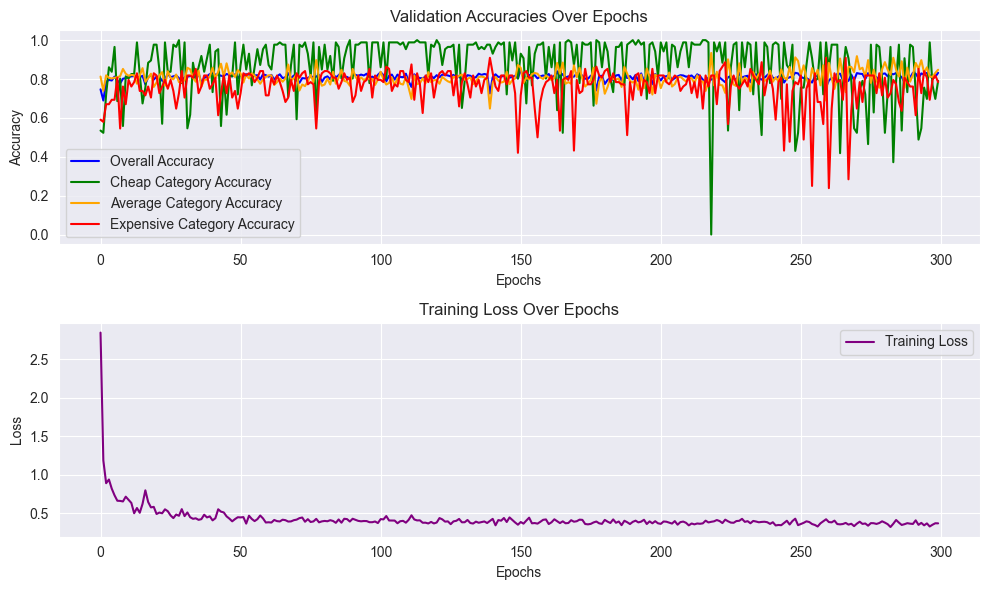

In [321]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(val_acc, label="Overall Accuracy", color="blue")
plt.plot(val_acc_cheap, label="Cheap Category Accuracy", color="green")
plt.plot(val_acc_average, label="Average Category Accuracy", color="orange")
plt.plot(val_acc_expensive, label="Expensive Category Accuracy", color="red")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracies Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_losses, label="Training Loss", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [322]:
(acc, acc_cheap, acc_average, acc_expensive) = evaluate(model, X_test_num, X_test_cat, Y_test)
print(f'Train set accuracies: {acc=:.3f} {acc_cheap=:.3f} {acc_average=:.3f} {acc_expensive=:.3f}')

Train set accuracies: acc=0.881 acc_cheap=0.865 acc_average=0.889 acc_expensive=0.863


## Przygotowanie wyników do zwrotu zadania

In [358]:
X_task_num = torch.from_numpy(X_task_num).cuda()
X_task_cat = torch.from_numpy(X_task_cat).cuda()

In [359]:
print(X_task_num[0])
print(X_task_cat[0])

tensor([-1.1314, -0.1133, -0.2619,  1.5114, -0.0830,  0.5495,  1.1712, -0.7577,
         1.1979,  1.3669], device='cuda:0', dtype=torch.float64)
tensor([1, 1, 0, 0, 2, 5], device='cuda:0')


In [360]:
with torch.no_grad():
    preds = model(X_task_num, X_task_cat)
    preds = preds.squeeze(dim=1)

In [361]:
preds_labeld = torch.zeros_like(preds)
preds_labeld[((preds>LOW_THRESHOLD) & (preds<HIGH_THRESHOLD))] = 1
preds_labeld[preds>HIGH_THRESHOLD] = 2

In [362]:
preds_labeld = preds_labeld.cpu().numpy()

In [375]:
preds_named = np.zeros_like(preds_labeld, dtype='U10')
preds_named[preds_labeld == 0] = 'cheap'
preds_named[preds_labeld == 1] = 'average'
preds_named[preds_labeld == 2] = 'expensive'
print(preds_named[0:10])

['average' 'expensive' 'expensive' 'average' 'average' 'expensive'
 'average' 'cheap' 'average' 'average']


In [376]:
df = pd.DataFrame(preds_named)
df.to_csv('środa_Celiński_Łukasiewicz_predykcje.csv', index=False)